# E-commerce Business Performance Analysis

This notebook provides a comprehensive analysis of e-commerce business metrics including revenue trends, customer behavior, product performance, and operational efficiency.

## Table of Contents
1. [Configuration & Setup](#configuration)
2. [Data Loading & Preparation](#data-loading)
3. [Data Quality Overview](#data-quality)
4. [Revenue Analysis](#revenue-analysis)
5. [Product Category Performance](#product-analysis)
6. [Geographic Performance](#geographic-analysis)
7. [Customer Experience Analysis](#customer-experience)
8. [Operational Metrics](#operational-metrics)
9. [Business Summary & Insights](#summary)

## Data Dictionary

**Key Business Terms:**
- **Revenue**: Total sales value from delivered orders (price only, excluding freight)
- **AOV (Average Order Value)**: Average total value per order
- **Order Growth**: Year-over-year change in number of orders
- **Review Score**: Customer satisfaction rating (1-5 scale)
- **Delivery Speed**: Days between order purchase and customer delivery

**Key Datasets:**
- `orders`: Order information including status and timestamps
- `order_items`: Individual items within orders with pricing
- `products`: Product catalog with categories and specifications
- `customers`: Customer location information
- `reviews`: Customer review scores and feedback

## 1. Configuration & Setup {#configuration}

Configure analysis parameters and import required libraries.

In [9]:
# Analysis Configuration
ANALYSIS_YEAR = 2023
COMPARISON_YEAR = 2022
DATA_PATH = 'ecommerce_data'

# Optional: Filter by specific months or quarters
# ANALYSIS_MONTHS = [1, 2, 3]  # Q1 only
# ANALYSIS_QUARTERS = [1, 2]   # First half of year
ANALYSIS_MONTHS = None  # Full year
ANALYSIS_QUARTERS = None  # Full year

print(f"Analysis Configuration:")
print(f"Primary Year: {ANALYSIS_YEAR}")
print(f"Comparison Year: {COMPARISON_YEAR}")
print(f"Data Path: {DATA_PATH}")
if ANALYSIS_MONTHS:
    print(f"Filtered to months: {ANALYSIS_MONTHS}")
if ANALYSIS_QUARTERS:
    print(f"Filtered to quarters: {ANALYSIS_QUARTERS}")

Analysis Configuration:
Primary Year: 2023
Comparison Year: 2022
Data Path: ecommerce_data


In [10]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

# Import custom modules
from data_loader import EcommerceDataLoader, load_and_prepare_data, create_configurable_date_filter
from business_metrics import (
    calculate_revenue_metrics,
    calculate_monthly_growth_trend,
    calculate_average_order_value,
    calculate_order_metrics,
    calculate_product_category_performance,
    calculate_geographic_performance,
    calculate_customer_satisfaction_metrics,
    calculate_order_status_distribution,
    generate_business_summary
)

# Configure display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')

# Set consistent color scheme
COLOR_PALETTE = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E']
plt.style.use('default')
sns.set_palette(COLOR_PALETTE)

print("Setup completed successfully!")

Setup completed successfully!


## 2. Data Loading & Preparation {#data-loading}

Load and prepare datasets for analysis with configurable date filtering.

In [11]:
# Load all datasets
sales_data, all_datasets = load_and_prepare_data(
    data_path=DATA_PATH,
    target_year=ANALYSIS_YEAR,
    comparison_year=COMPARISON_YEAR
)

# Extract individual datasets for convenience
orders = all_datasets['orders']
order_items = all_datasets['order_items']
products = all_datasets['products']
customers = all_datasets['customers']
reviews = all_datasets['reviews']

print(f"\nDataset shapes:")
for name, df in all_datasets.items():
    print(f"{name}: {df.shape}")

Loaded orders: 10000 rows
Loaded order_items: 16047 rows
Loaded products: 6000 rows
Loaded customers: 8000 rows
Loaded reviews: 6571 rows
Loaded payments: 14091 rows

Data loaded successfully!
Sales data shape: (15095, 15)
Date range: 2021-12-31 16:55:08.451178 to 2024-01-01 04:12:51.260674
Years available: [np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024)]

Dataset shapes:
orders: (10000, 12)
order_items: (16047, 8)
products: (6000, 10)
customers: (8000, 5)
reviews: (6571, 7)
payments: (14091, 5)


In [12]:
# Apply configurable date filtering if specified
if ANALYSIS_MONTHS or ANALYSIS_QUARTERS:
    print("Applying date filters to sales data...")
    sales_data_filtered = create_configurable_date_filter(
        sales_data,
        months=ANALYSIS_MONTHS,
        quarters=ANALYSIS_QUARTERS
    )
    print(f"Filtered data shape: {sales_data_filtered.shape} (from {sales_data.shape})")
    sales_data = sales_data_filtered

# Display sample of prepared sales data
print("\nSales Data Sample:")
display(sales_data.head())

print(f"\nDate Range: {sales_data['order_purchase_timestamp'].min()} to {sales_data['order_purchase_timestamp'].max()}")
print(f"Years in dataset: {sorted(sales_data['year'].unique())}")


Sales Data Sample:


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_value,order_status,order_purchase_timestamp,order_delivered_customer_date,order_year,order_month,year,month
2,ord_5fa044951857e02fd1347b47,1,prod_9b6f1793388ae983f852d189,sell_34212979d97b6d1a8409a01e,2025-07-19 21:15:46.994884,111.91,9.50,121.41,delivered,2023-04-24 13:05:32.579655,2023-05-01 02:05:32.579655,2023,4,2023,4
3,ord_5fa044951857e02fd1347b47,2,prod_c7b5997a4d0061a9f50e874c,sell_4668fb88b81f8d834371c335,2025-07-17 10:00:54.671461,878.42,77.50,955.92,delivered,2023-04-24 13:05:32.579655,2023-05-01 02:05:32.579655,2023,4,2023,4
4,ord_0a02a8a1d3d282380ed7d0cc,1,prod_d5f7b6e420ea5cffc504ab21,sell_a9c81e2ceb456688ecf8e944,2025-08-08 16:24:49.849198,1030.31,15.47,1045.78,delivered,2022-05-15 07:51:22.471390,2022-05-23 01:51:22.471390,2022,5,2022,5
5,ord_0a02a8a1d3d282380ed7d0cc,2,prod_01b00f21c2758bf94f51234f,sell_2d8081195880ffc32896b0cf,2025-07-31 00:03:29.430312,1299.50,232.29,1531.79,delivered,2022-05-15 07:51:22.471390,2022-05-23 01:51:22.471390,2022,5,2022,5
6,ord_8a243422e3ad7ab97a1fe175,1,prod_a904d724d4b2b8f571e66f19,sell_74a4d7dc6c64cb629f4e06d7,2025-07-18 12:23:13.595408,1307.04,55.16,1362.20,delivered,2022-04-18 15:02:44.122280,2022-04-30 16:02:44.122280,2022,4,2022,4



Date Range: 2021-12-31 16:55:08.451178 to 2024-01-01 04:12:51.260674
Years in dataset: [np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024)]


## 3. Data Quality Overview {#data-quality}

Assess data quality and completeness across all datasets.

In [13]:
# Initialize data loader for quality checks
loader = EcommerceDataLoader(DATA_PATH)
loader.datasets = all_datasets

# Get data quality report
quality_report = loader.validate_data_quality()
summary_report = loader.get_dataset_summary()

# Create quality overview table
quality_df = pd.DataFrame({
    'Dataset': list(quality_report.keys()),
    'Rows': [summary_report[k]['rows'] for k in quality_report.keys()],
    'Columns': [summary_report[k]['columns'] for k in quality_report.keys()],
    'Duplicates': [quality_report[k]['duplicate_rows'] for k in quality_report.keys()],
    'Memory (MB)': [round(summary_report[k]['memory_usage_mb'], 2) for k in quality_report.keys()]
})

print("Data Quality Overview:")
display(quality_df)

# Check for missing data in key columns
key_missing = pd.DataFrame({
    'orders': {
        'order_purchase_timestamp': orders['order_purchase_timestamp'].isnull().sum(),
        'order_status': orders['order_status'].isnull().sum(),
        'customer_id': orders['customer_id'].isnull().sum()
    },
    'order_items': {
        'price': order_items['price'].isnull().sum(),
        'product_id': order_items['product_id'].isnull().sum(),
        'order_id': order_items['order_id'].isnull().sum()
    },
    'products': {
        'product_category_name': products['product_category_name'].isnull().sum(),
        'product_id': products['product_id'].isnull().sum()
    }
}).fillna(0)

print("\nMissing Values in Key Columns:")
display(key_missing)

Data Quality Overview:


,Dataset,Rows,Columns,Duplicates,Memory (MB)
0,orders,10000,12,0,2.56
1,order_items,16047,8,0,4.18
2,products,6000,10,0,1.18
3,customers,8000,5,0,2.08
4,reviews,6571,7,0,2.32
5,payments,14091,5,0,2.15



Missing Values in Key Columns:


,orders,order_items,products
order_purchase_timestamp,0.0,0.0,0.0
order_status,0.0,0.0,0.0
customer_id,0.0,0.0,0.0
price,0.0,0.0,0.0
product_id,0.0,0.0,0.0
order_id,0.0,0.0,0.0
product_category_name,0.0,0.0,0.0


## 4. Revenue Analysis {#revenue-analysis}

Comprehensive analysis of revenue performance including year-over-year comparisons and trends.

In [14]:
# Calculate revenue metrics
revenue_metrics = calculate_revenue_metrics(
    sales_data, 
    current_period_col='year',
    current_period=ANALYSIS_YEAR, 
    comparison_period=COMPARISON_YEAR
)

# Calculate monthly growth trend
monthly_growth = calculate_monthly_growth_trend(sales_data, ANALYSIS_YEAR)

# Calculate AOV metrics
aov_metrics = calculate_average_order_value(
    sales_data,
    current_period_col='year',
    current_period=ANALYSIS_YEAR,
    comparison_period=COMPARISON_YEAR
)

# Calculate order metrics
order_metrics = calculate_order_metrics(
    sales_data,
    current_period_col='year', 
    current_period=ANALYSIS_YEAR,
    comparison_period=COMPARISON_YEAR
)

# Display key metrics
print(f"REVENUE ANALYSIS - {ANALYSIS_YEAR}")
print("=" * 40)
print(f"Total Revenue: ${revenue_metrics['current_revenue']:,.2f}")
print(f"Revenue Growth (YoY): {revenue_metrics['revenue_growth_pct']:.2f}%")
print(f"")
print(f"Total Orders: {order_metrics['current_orders']:,}")
print(f"Order Growth (YoY): {order_metrics['order_growth_pct']:.2f}%")
print(f"")
print(f"Average Order Value: ${aov_metrics['current_aov']:.2f}")
print(f"AOV Growth (YoY): {aov_metrics['aov_growth_pct']:.2f}%")
print(f"")
print(f"Average Monthly Growth: {monthly_growth.mean()*100:.2f}%")

REVENUE ANALYSIS - 2023
Total Revenue: $3,360,294.74
Revenue Growth (YoY): -2.46%

Total Orders: 4,635
Order Growth (YoY): -2.40%

Average Order Value: $724.98
AOV Growth (YoY): -0.06%

Average Monthly Growth: -0.39%


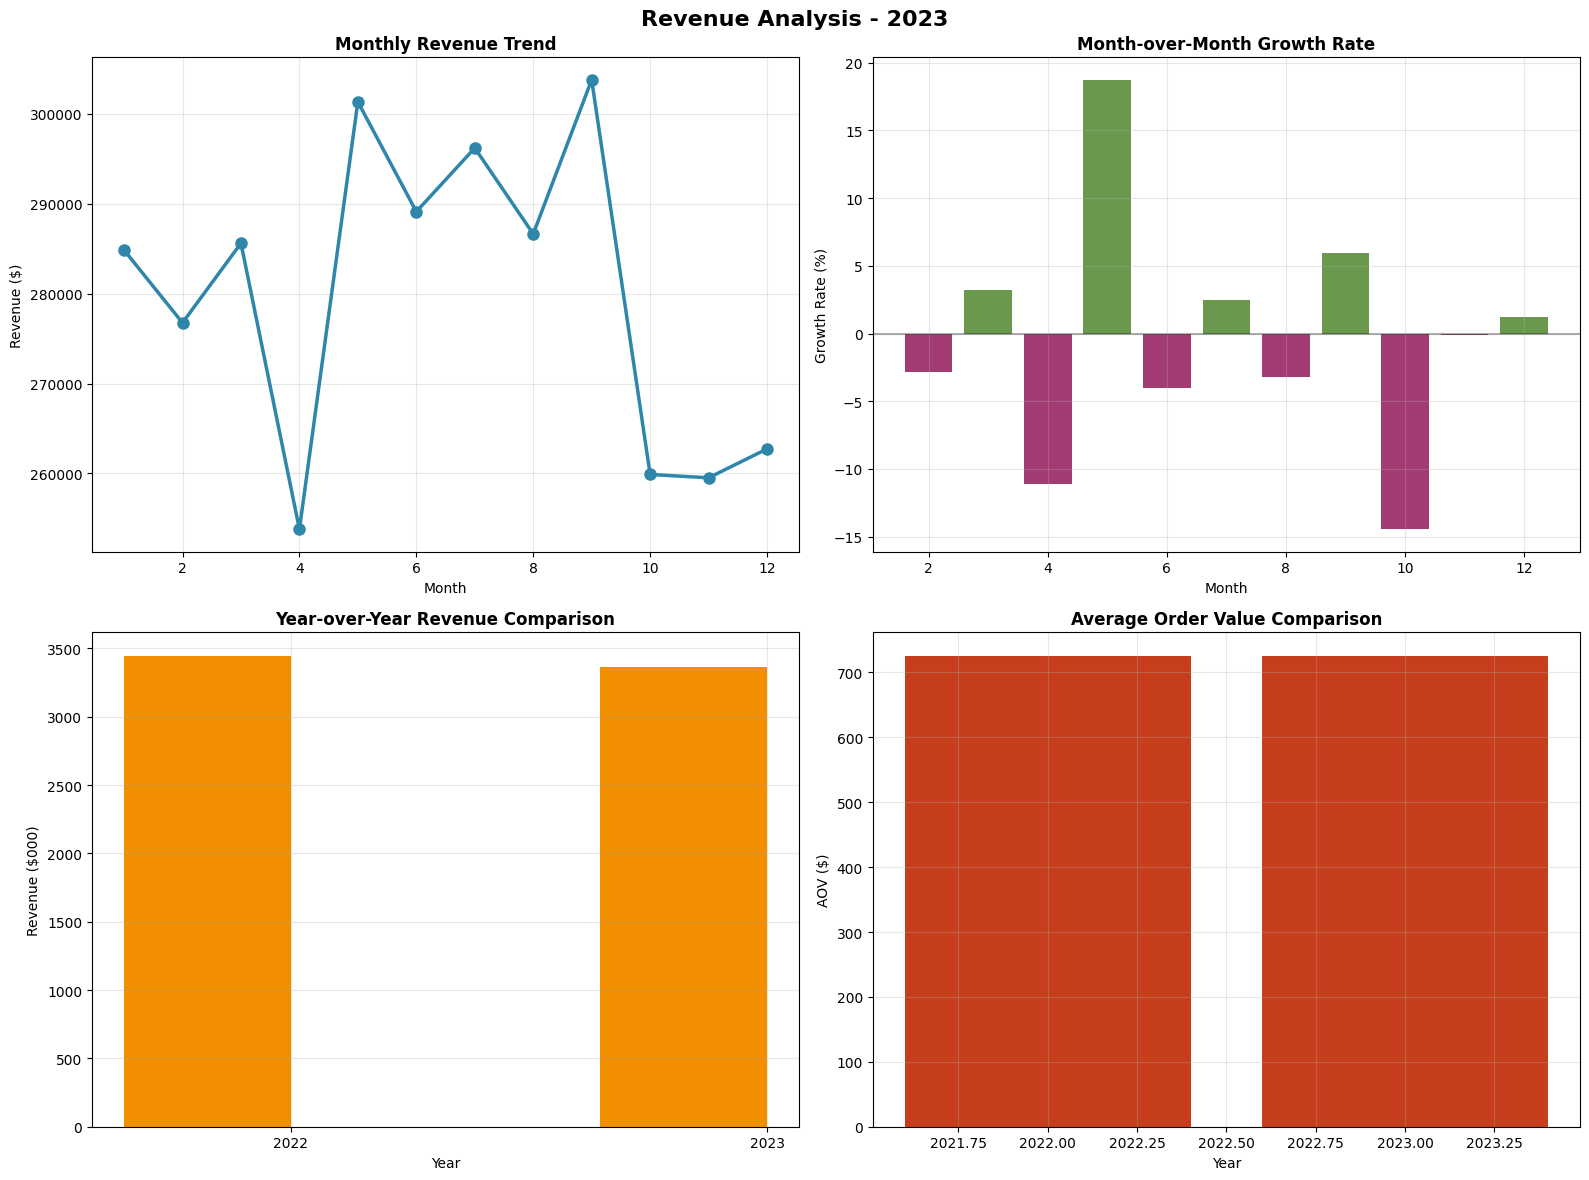

In [15]:
# Revenue trend visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Revenue Analysis - {ANALYSIS_YEAR}', fontsize=16, fontweight='bold')

# Monthly revenue trend
monthly_revenue = sales_data[sales_data['year'] == ANALYSIS_YEAR].groupby('month')['price'].sum()
axes[0, 0].plot(monthly_revenue.index, monthly_revenue.values, 
                marker='o', linewidth=2.5, markersize=8, color=COLOR_PALETTE[0])
axes[0, 0].set_title('Monthly Revenue Trend', fontweight='bold')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Revenue ($)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].ticklabel_format(style='plain', axis='y')

# Month-over-month growth
growth_data = monthly_growth.dropna() * 100
colors = [COLOR_PALETTE[1] if x < 0 else COLOR_PALETTE[4] for x in growth_data.values]
axes[0, 1].bar(growth_data.index, growth_data.values, color=colors)
axes[0, 1].set_title('Month-over-Month Growth Rate', fontweight='bold')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Growth Rate (%)')
axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[0, 1].grid(True, alpha=0.3)

# Year-over-year comparison
yearly_comparison = pd.DataFrame({
    'Year': [COMPARISON_YEAR, ANALYSIS_YEAR],
    'Revenue': [revenue_metrics['comparison_revenue'], revenue_metrics['current_revenue']],
    'Orders': [order_metrics['comparison_orders'], order_metrics['current_orders']]
})

x = np.arange(len(yearly_comparison))
width = 0.35

bars1 = axes[1, 0].bar(x - width/2, yearly_comparison['Revenue']/1000, 
                       width, label='Revenue (Thousands)', color=COLOR_PALETTE[2])
axes[1, 0].set_title('Year-over-Year Revenue Comparison', fontweight='bold')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Revenue ($000)')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(yearly_comparison['Year'])
axes[1, 0].grid(True, alpha=0.3)

# AOV comparison
aov_comparison = [aov_metrics['comparison_aov'], aov_metrics['current_aov']]
axes[1, 1].bar(yearly_comparison['Year'], aov_comparison, color=COLOR_PALETTE[3])
axes[1, 1].set_title('Average Order Value Comparison', fontweight='bold')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('AOV ($)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Product Category Performance {#product-analysis}

Analysis of sales performance across different product categories.

In [16]:
# Calculate product category performance
category_performance = calculate_product_category_performance(
    sales_data, products, 'year', ANALYSIS_YEAR
)

print(f"PRODUCT CATEGORY PERFORMANCE - {ANALYSIS_YEAR}")
print("=" * 50)
display(category_performance)

# Top categories summary
print(f"\nTop 5 Categories by Revenue:")
top_categories = category_performance.head(5)
for idx, row in top_categories.iterrows():
    print(f"{idx}: ${row['total_revenue']:,.2f} ({row['total_orders']} orders, ${row['avg_order_value']:.2f} AOV)")

PRODUCT CATEGORY PERFORMANCE - 2023


,total_revenue,total_orders,avg_order_value
product_category_name,,,
electronics,1401359.21,1327,1056.035576
home_garden,862653.27,1149,750.786136
sports_outdoors,278845.32,686,406.480058
automotive,247707.10,489,506.558487
clothing_shoes_jewelry,232745.04,884,263.286244
toys_games,70163.64,476,147.402605
health_personal_care,65370.27,630,103.762333
tools_home_improvement,54280.33,219,247.855388
beauty_personal_care,49213.30,315,156.232698



Top 5 Categories by Revenue:
electronics: $1,401,359.21 (1327.0 orders, $1056.04 AOV)
home_garden: $862,653.27 (1149.0 orders, $750.79 AOV)
sports_outdoors: $278,845.32 (686.0 orders, $406.48 AOV)
automotive: $247,707.10 (489.0 orders, $506.56 AOV)
clothing_shoes_jewelry: $232,745.04 (884.0 orders, $263.29 AOV)


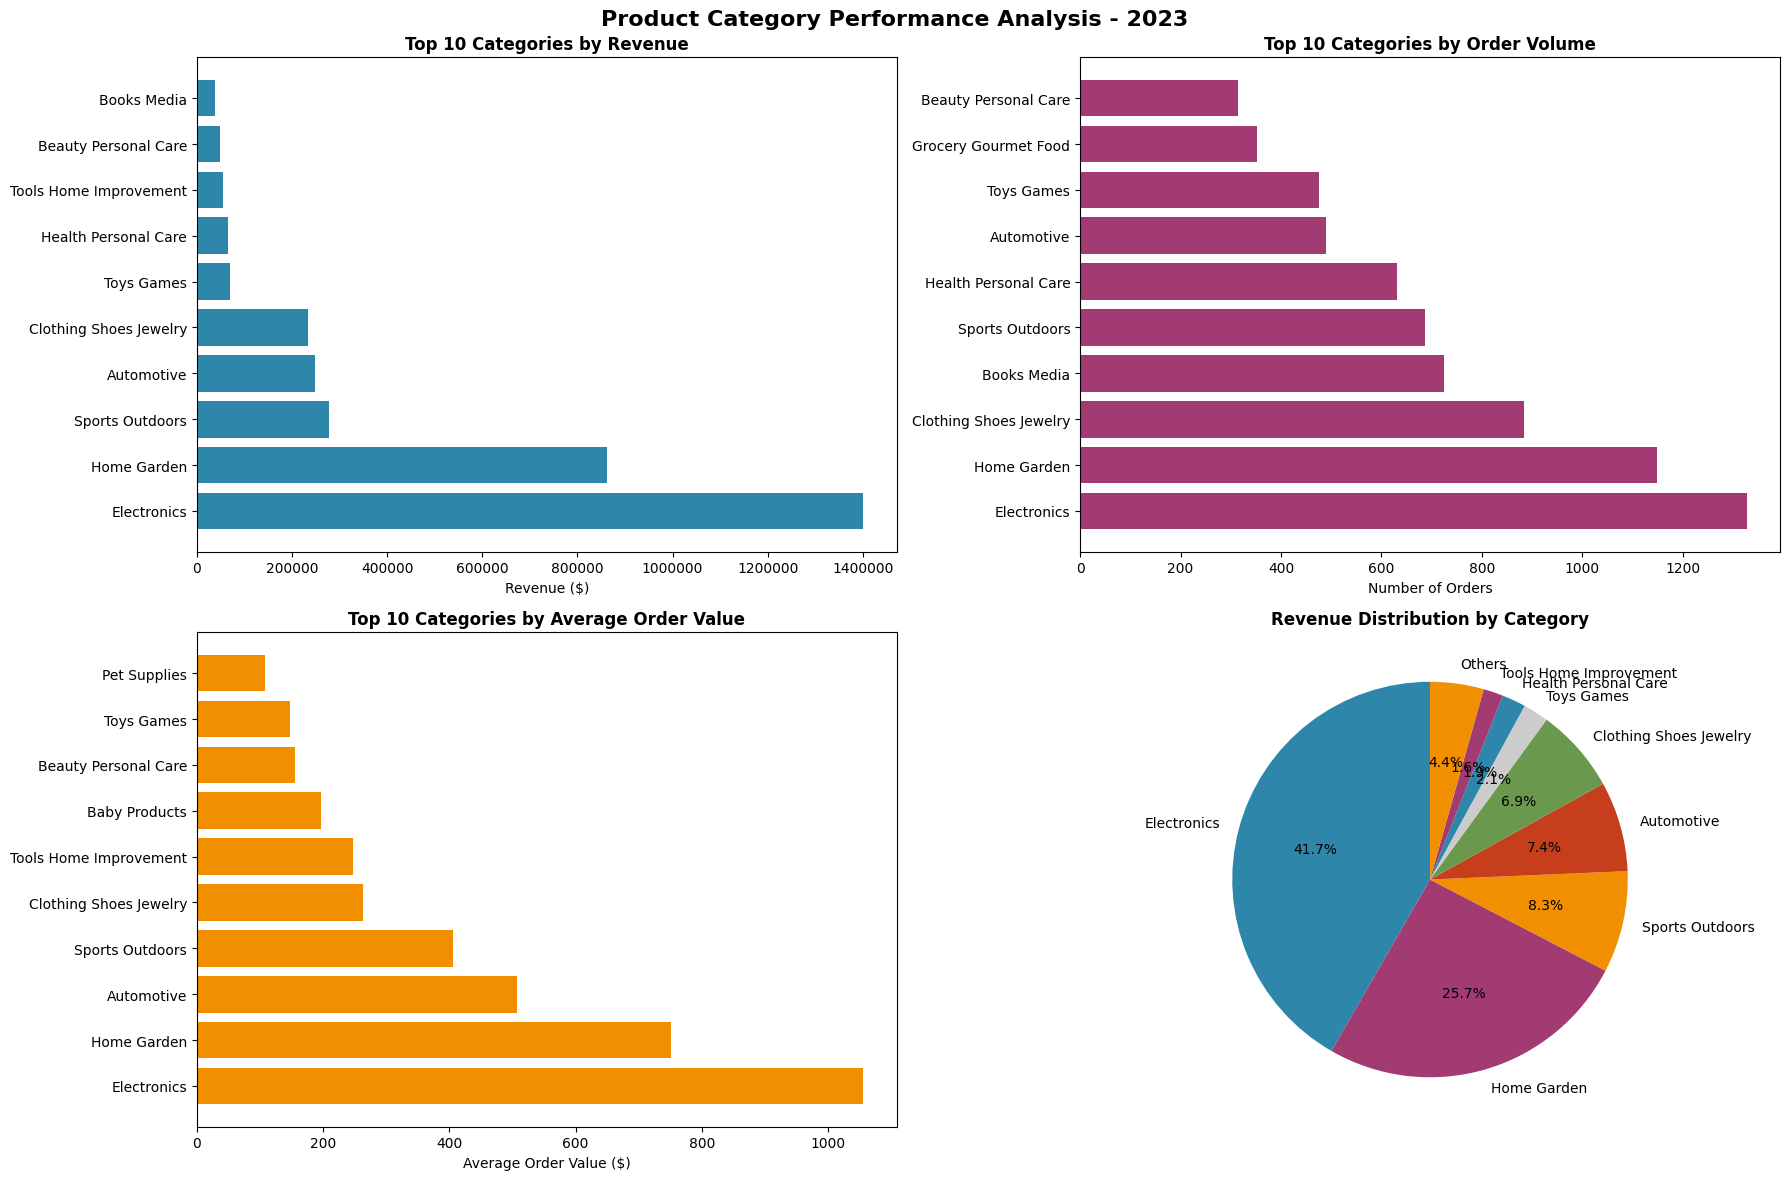

In [17]:
# Product category visualizations
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle(f'Product Category Performance Analysis - {ANALYSIS_YEAR}', fontsize=16, fontweight='bold')

# Revenue by category (top 10)
top_10_revenue = category_performance.head(10)
axes[0, 0].barh(range(len(top_10_revenue)), top_10_revenue['total_revenue'], 
                color=COLOR_PALETTE[0])
axes[0, 0].set_yticks(range(len(top_10_revenue)))
axes[0, 0].set_yticklabels([name.replace('_', ' ').title() for name in top_10_revenue.index])
axes[0, 0].set_title('Top 10 Categories by Revenue', fontweight='bold')
axes[0, 0].set_xlabel('Revenue ($)')
axes[0, 0].ticklabel_format(style='plain', axis='x')

# Order volume by category (top 10)
top_10_orders = category_performance.sort_values('total_orders', ascending=False).head(10)
axes[0, 1].barh(range(len(top_10_orders)), top_10_orders['total_orders'], 
                color=COLOR_PALETTE[1])
axes[0, 1].set_yticks(range(len(top_10_orders)))
axes[0, 1].set_yticklabels([name.replace('_', ' ').title() for name in top_10_orders.index])
axes[0, 1].set_title('Top 10 Categories by Order Volume', fontweight='bold')
axes[0, 1].set_xlabel('Number of Orders')

# AOV by category (top 10)
top_10_aov = category_performance.sort_values('avg_order_value', ascending=False).head(10)
axes[1, 0].barh(range(len(top_10_aov)), top_10_aov['avg_order_value'], 
                color=COLOR_PALETTE[2])
axes[1, 0].set_yticks(range(len(top_10_aov)))
axes[1, 0].set_yticklabels([name.replace('_', ' ').title() for name in top_10_aov.index])
axes[1, 0].set_title('Top 10 Categories by Average Order Value', fontweight='bold')
axes[1, 0].set_xlabel('Average Order Value ($)')

# Revenue distribution pie chart (top 8 + others)
top_8_categories = category_performance.head(8)
others_revenue = category_performance.iloc[8:]['total_revenue'].sum()
pie_data = list(top_8_categories['total_revenue']) + [others_revenue]
pie_labels = [name.replace('_', ' ').title() for name in top_8_categories.index] + ['Others']

axes[1, 1].pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=90,
               colors=COLOR_PALETTE + ['#CCCCCC'])
axes[1, 1].set_title('Revenue Distribution by Category', fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Geographic Performance {#geographic-analysis}

Analysis of sales performance across different states and geographic regions.

In [18]:
# Calculate geographic performance
state_performance = calculate_geographic_performance(
    sales_data, orders, customers, 'year', ANALYSIS_YEAR
)

print(f"GEOGRAPHIC PERFORMANCE - {ANALYSIS_YEAR}")
print("=" * 40)
print(f"\nTop 10 States by Revenue:")
display(state_performance.head(10))

# Summary statistics
print(f"\nGeographic Summary:")
print(f"Total States: {len(state_performance)}")
print(f"Top State: {state_performance.index[0]} (${state_performance.iloc[0]['total_revenue']:,.2f})")
print(f"Top 5 States Account for: {state_performance.head(5)['total_revenue'].sum() / state_performance['total_revenue'].sum() * 100:.1f}% of revenue")

GEOGRAPHIC PERFORMANCE - 2023

Top 10 States by Revenue:


,total_revenue,total_orders,avg_order_value
customer_state,,,
CA,537880.74,1226,438.728173
TX,403303.49,869,464.100679
FL,310195.84,707,438.749420
NY,253111.85,632,400.493434
IL,185930.89,404,460.224975
PA,173260.68,351,493.620171
OH,157619.72,339,464.954926
GA,146414.65,306,478.479248
MI,132325.60,326,405.906748



Geographic Summary:
Total States: 20
Top State: CA ($537,880.74)
Top 5 States Account for: 50.3% of revenue


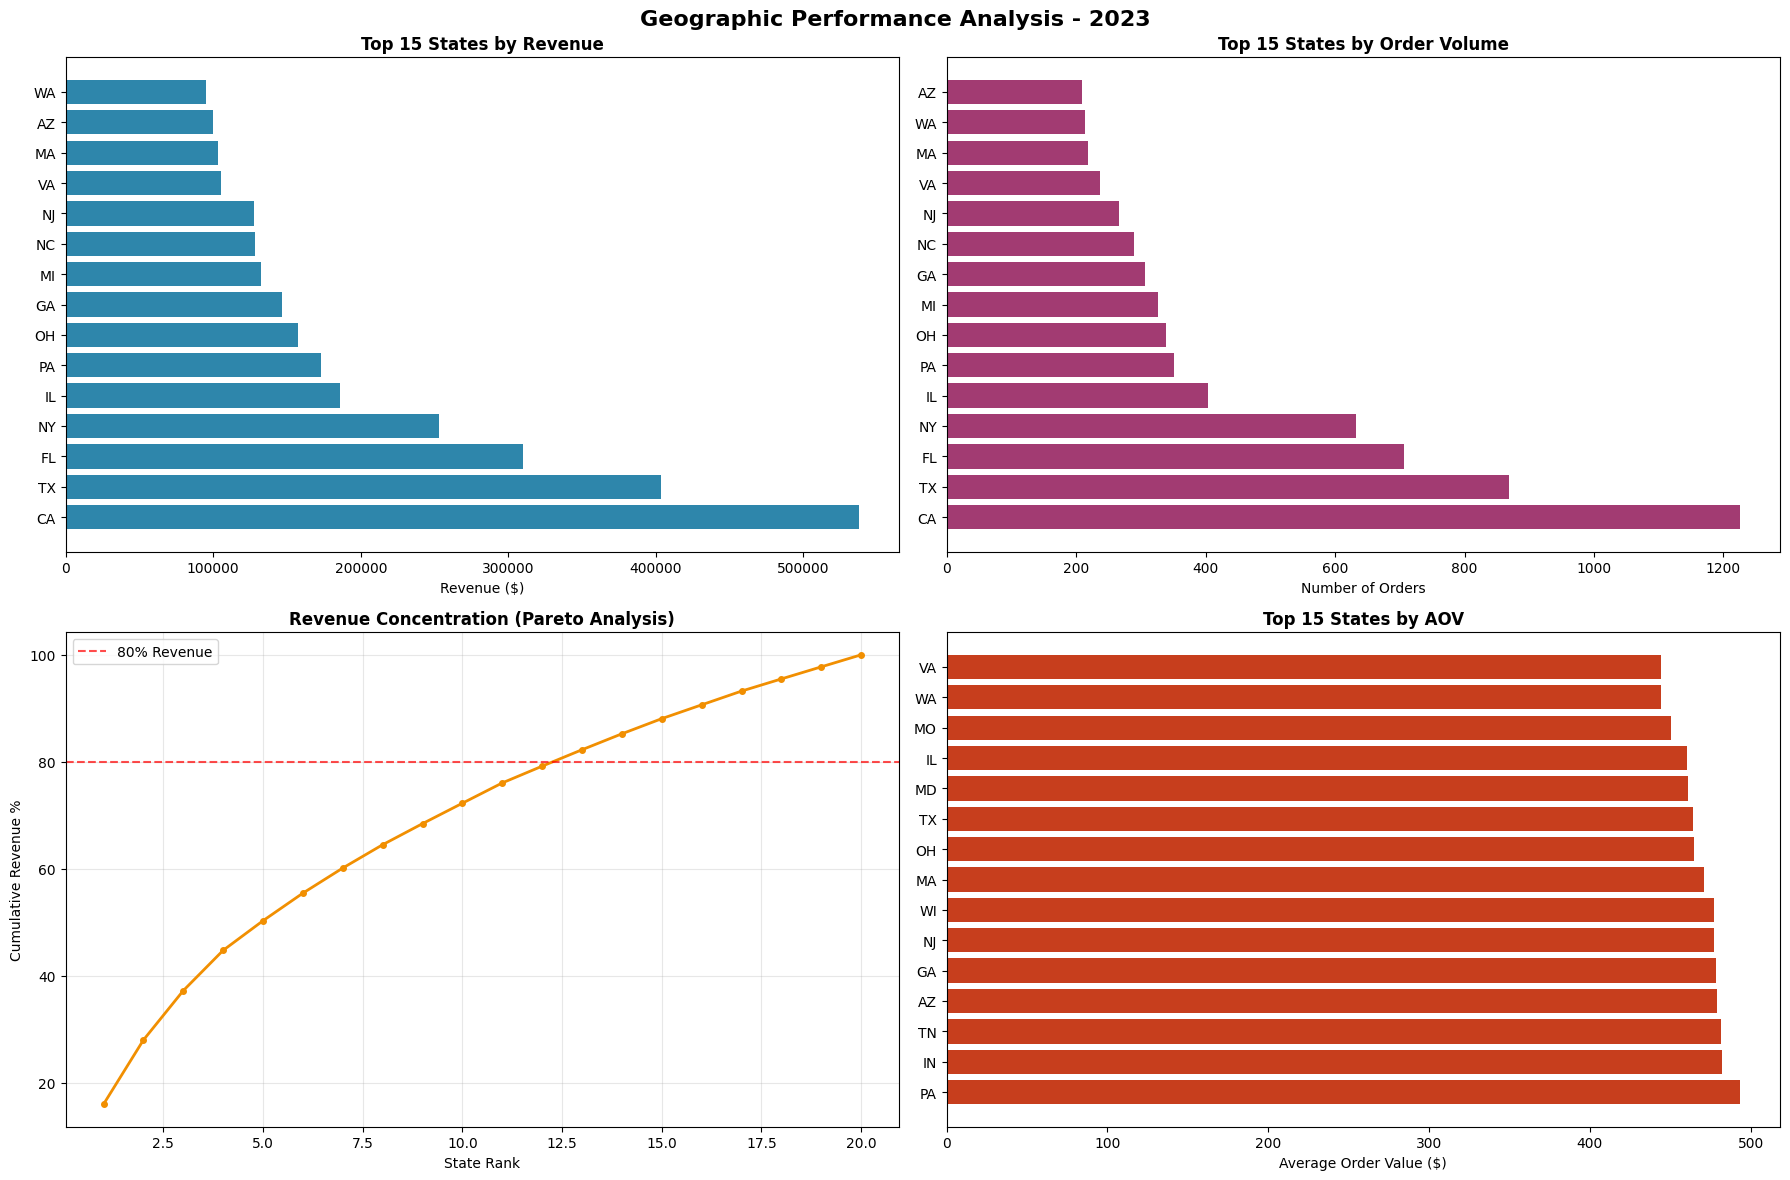

In [19]:
# Geographic visualizations
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle(f'Geographic Performance Analysis - {ANALYSIS_YEAR}', fontsize=16, fontweight='bold')

# Top 15 states by revenue
top_15_states = state_performance.head(15)
axes[0, 0].barh(range(len(top_15_states)), top_15_states['total_revenue'],
                color=COLOR_PALETTE[0])
axes[0, 0].set_yticks(range(len(top_15_states)))
axes[0, 0].set_yticklabels(top_15_states.index)
axes[0, 0].set_title('Top 15 States by Revenue', fontweight='bold')
axes[0, 0].set_xlabel('Revenue ($)')
axes[0, 0].ticklabel_format(style='plain', axis='x')

# Top 15 states by order volume
top_15_orders = state_performance.sort_values('total_orders', ascending=False).head(15)
axes[0, 1].barh(range(len(top_15_orders)), top_15_orders['total_orders'],
                color=COLOR_PALETTE[1])
axes[0, 1].set_yticks(range(len(top_15_orders)))
axes[0, 1].set_yticklabels(top_15_orders.index)
axes[0, 1].set_title('Top 15 States by Order Volume', fontweight='bold')
axes[0, 1].set_xlabel('Number of Orders')

# Revenue concentration
cumulative_revenue = state_performance['total_revenue'].cumsum()
cumulative_pct = cumulative_revenue / cumulative_revenue.iloc[-1] * 100
axes[1, 0].plot(range(1, len(cumulative_pct) + 1), cumulative_pct, 
                marker='o', linewidth=2, markersize=4, color=COLOR_PALETTE[2])
axes[1, 0].axhline(y=80, color='red', linestyle='--', alpha=0.7, label='80% Revenue')
axes[1, 0].set_title('Revenue Concentration (Pareto Analysis)', fontweight='bold')
axes[1, 0].set_xlabel('State Rank')
axes[1, 0].set_ylabel('Cumulative Revenue %')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# AOV distribution by state (top 15)
top_15_aov = state_performance.sort_values('avg_order_value', ascending=False).head(15)
axes[1, 1].barh(range(len(top_15_aov)), top_15_aov['avg_order_value'],
                color=COLOR_PALETTE[3])
axes[1, 1].set_yticks(range(len(top_15_aov)))
axes[1, 1].set_yticklabels(top_15_aov.index)
axes[1, 1].set_title('Top 15 States by AOV', fontweight='bold')
axes[1, 1].set_xlabel('Average Order Value ($)')

plt.tight_layout()
plt.show()

In [20]:
# Interactive geographic map using Plotly
state_performance_reset = state_performance.reset_index()

fig = px.choropleth(
    state_performance_reset,
    locations='customer_state',
    color='total_revenue',
    locationmode='USA-states',
    scope='usa',
    title=f'Revenue by State - {ANALYSIS_YEAR}',
    color_continuous_scale='Reds',
    labels={'total_revenue': 'Revenue ($)'},
    hover_data=['total_orders', 'avg_order_value']
)

fig.update_layout(
    title_x=0.5,
    font_size=12,
    width=900,
    height=600
)

fig.show()

## 7. Customer Experience Analysis {#customer-experience}

Analysis of customer satisfaction metrics including review scores and delivery performance.

In [21]:
# Calculate customer satisfaction metrics
satisfaction_metrics = calculate_customer_satisfaction_metrics(
    sales_data, reviews, 'year', ANALYSIS_YEAR
)

print(f"CUSTOMER EXPERIENCE ANALYSIS - {ANALYSIS_YEAR}")
print("=" * 50)
print(f"Average Review Score: {satisfaction_metrics['avg_review_score']:.2f}/5.0")
print(f"Average Delivery Time: {satisfaction_metrics['avg_delivery_time_days']:.1f} days")
print(f"")
print(f"Satisfaction by Delivery Speed:")
for speed, score in satisfaction_metrics['satisfaction_by_delivery_speed'].items():
    print(f"  {speed}: {score:.2f}/5.0")

# Get review score distribution
analysis_orders = sales_data[sales_data['year'] == ANALYSIS_YEAR]
review_data = pd.merge(analysis_orders[['order_id']], reviews[['order_id', 'review_score']], on='order_id')
review_distribution = review_data['review_score'].value_counts(normalize=True).sort_index()

print(f"\nReview Score Distribution:")
for score, pct in review_distribution.items():
    print(f"  {score} stars: {pct*100:.1f}%")

CUSTOMER EXPERIENCE ANALYSIS - 2023
Average Review Score: 4.10/5.0
Average Delivery Time: 8.0 days

Satisfaction by Delivery Speed:
  1-3 days: 4.19/5.0
  4-7 days: 4.08/5.0
  8+ days: 4.11/5.0

Review Score Distribution:
  1 stars: 3.6%
  2 stars: 6.9%
  3 stars: 15.4%
  4 stars: 24.3%
  5 stars: 49.9%


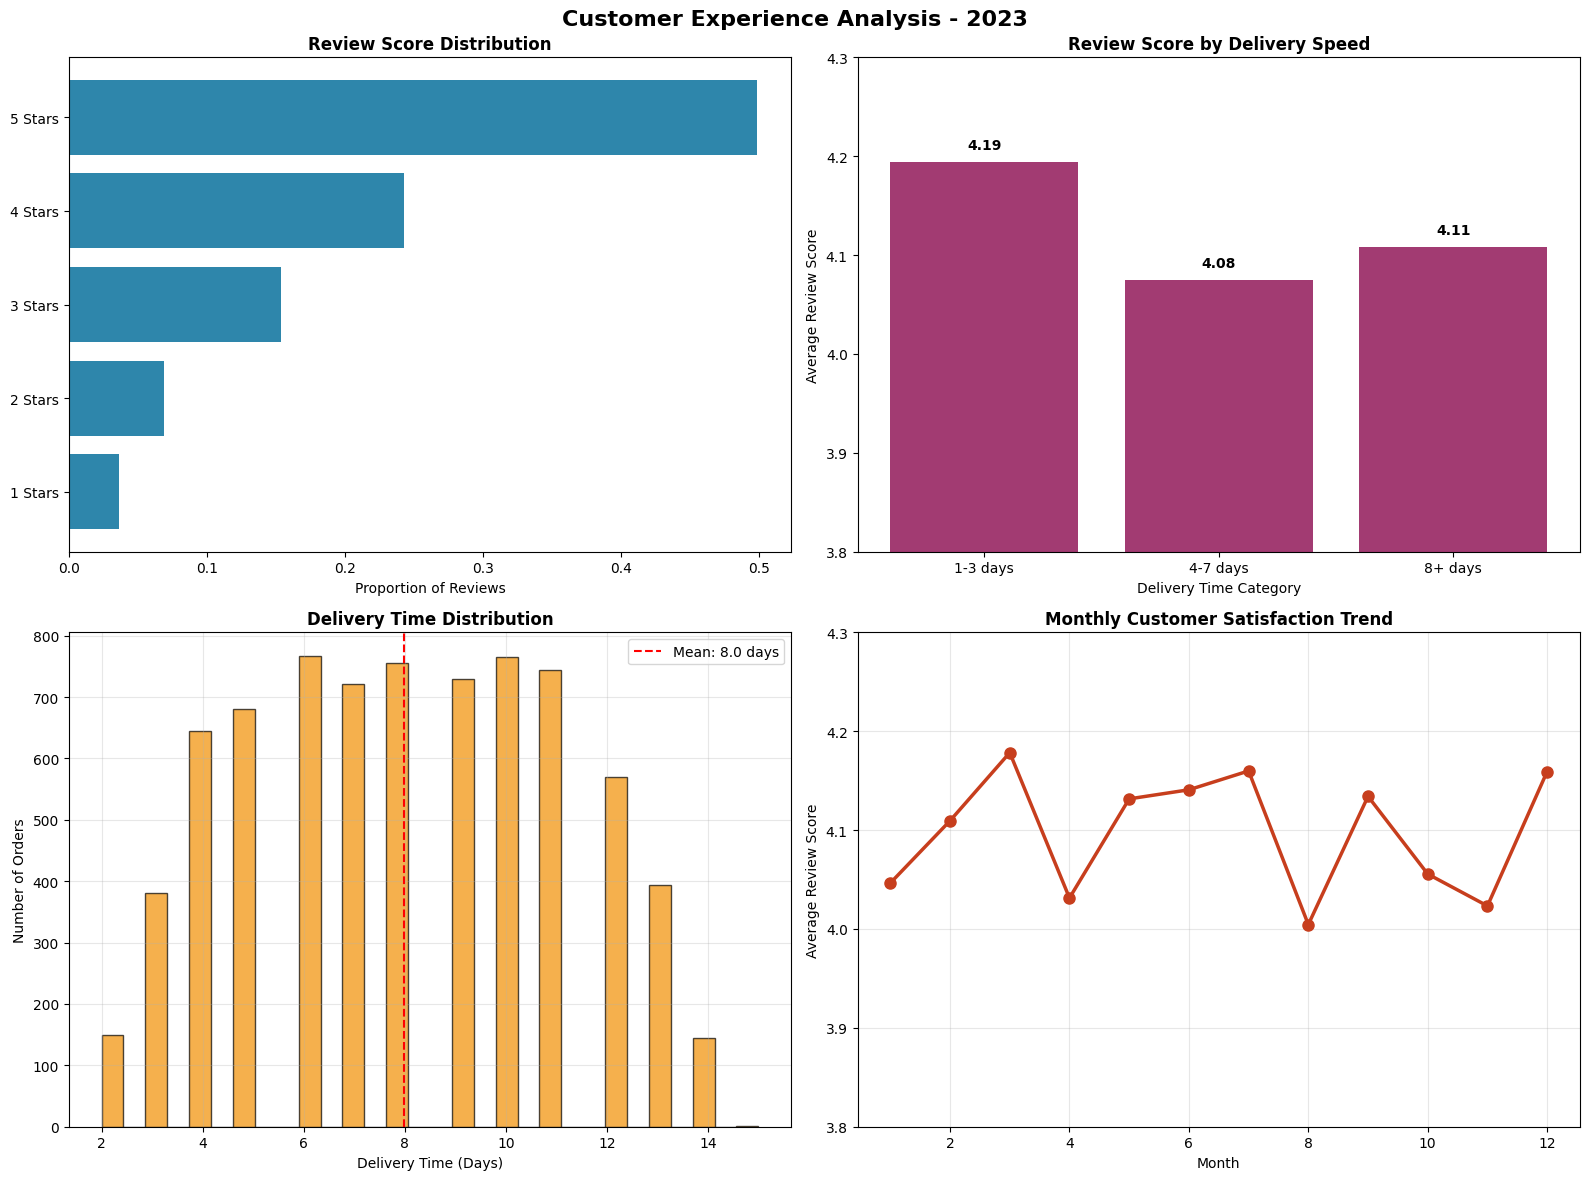

In [22]:
# Customer experience visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Customer Experience Analysis - {ANALYSIS_YEAR}', fontsize=16, fontweight='bold')

# Review score distribution
axes[0, 0].barh(range(len(review_distribution)), review_distribution.values,
                color=COLOR_PALETTE[0])
axes[0, 0].set_yticks(range(len(review_distribution)))
axes[0, 0].set_yticklabels([f'{int(score)} Stars' for score in review_distribution.index])
axes[0, 0].set_title('Review Score Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Proportion of Reviews')

# Satisfaction by delivery speed
delivery_satisfaction = satisfaction_metrics['satisfaction_by_delivery_speed']
delivery_categories = list(delivery_satisfaction.keys())
satisfaction_scores = list(delivery_satisfaction.values())

bars = axes[0, 1].bar(delivery_categories, satisfaction_scores, color=COLOR_PALETTE[1])
axes[0, 1].set_title('Review Score by Delivery Speed', fontweight='bold')
axes[0, 1].set_xlabel('Delivery Time Category')
axes[0, 1].set_ylabel('Average Review Score')
axes[0, 1].set_ylim(3.8, 4.3)
for bar, score in zip(bars, satisfaction_scores):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{score:.2f}', ha='center', va='bottom', fontweight='bold')

# Delivery time distribution
delivery_data = sales_data[sales_data['year'] == ANALYSIS_YEAR].copy()
delivery_data['order_delivered_customer_date'] = pd.to_datetime(delivery_data['order_delivered_customer_date'])
delivery_data['delivery_days'] = (delivery_data['order_delivered_customer_date'] - 
                                 delivery_data['order_purchase_timestamp']).dt.days
delivery_data = delivery_data.dropna(subset=['delivery_days'])

axes[1, 0].hist(delivery_data['delivery_days'], bins=30, color=COLOR_PALETTE[2], alpha=0.7, edgecolor='black')
axes[1, 0].axvline(delivery_data['delivery_days'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {delivery_data["delivery_days"].mean():.1f} days')
axes[1, 0].set_title('Delivery Time Distribution', fontweight='bold')
axes[1, 0].set_xlabel('Delivery Time (Days)')
axes[1, 0].set_ylabel('Number of Orders')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Monthly customer satisfaction trend
monthly_satisfaction = (sales_data[sales_data['year'] == ANALYSIS_YEAR]
                       .merge(reviews[['order_id', 'review_score']], on='order_id')
                       .groupby('month')['review_score'].mean())

axes[1, 1].plot(monthly_satisfaction.index, monthly_satisfaction.values,
                marker='o', linewidth=2.5, markersize=8, color=COLOR_PALETTE[3])
axes[1, 1].set_title('Monthly Customer Satisfaction Trend', fontweight='bold')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Average Review Score')
axes[1, 1].set_ylim(3.8, 4.3)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Operational Metrics {#operational-metrics}

Analysis of operational performance including order fulfillment and status distribution.

In [23]:
# Calculate order status distribution
status_distribution = calculate_order_status_distribution(
    orders, 'year', ANALYSIS_YEAR
)

print(f"OPERATIONAL METRICS - {ANALYSIS_YEAR}")
print("=" * 40)
print(f"Order Status Distribution:")
for status, pct in status_distribution.items():
    print(f"  {status.capitalize()}: {pct*100:.1f}%")

# Calculate fulfillment metrics
total_orders_analysis = orders[orders['order_year'] == ANALYSIS_YEAR]
delivered_rate = status_distribution.get('delivered', 0) * 100
cancelled_rate = status_distribution.get('canceled', 0) * 100
pending_rate = (status_distribution.get('pending', 0) + 
                status_distribution.get('processing', 0) + 
                status_distribution.get('shipped', 0)) * 100

print(f"\nFulfillment Metrics:")
print(f"  Delivery Rate: {delivered_rate:.1f}%")
print(f"  Cancellation Rate: {cancelled_rate:.1f}%")
print(f"  In-Progress Rate: {pending_rate:.1f}%")

# Average delivery time for delivered orders
delivered_orders = orders[(orders['order_year'] == ANALYSIS_YEAR) & 
                         (orders['order_status'] == 'delivered')].copy()
if len(delivered_orders) > 0:
    delivered_orders['delivery_time'] = (
        delivered_orders['order_delivered_customer_date'] - 
        delivered_orders['order_purchase_timestamp']
    ).dt.days
    avg_delivery_time = delivered_orders['delivery_time'].mean()
    print(f"\nDelivery Performance:")
    print(f"  Average Delivery Time: {avg_delivery_time:.1f} days")
    print(f"  Median Delivery Time: {delivered_orders['delivery_time'].median():.1f} days")
    print(f"  95th Percentile: {delivered_orders['delivery_time'].quantile(0.95):.1f} days")

OPERATIONAL METRICS - 2023
Order Status Distribution:
  Delivered: 93.6%
  Shipped: 3.2%
  Canceled: 1.3%
  Processing: 1.2%
  Pending: 0.5%
  Returned: 0.2%

Fulfillment Metrics:
  Delivery Rate: 93.6%
  Cancellation Rate: 1.3%
  In-Progress Rate: 4.9%

Delivery Performance:
  Average Delivery Time: 8.0 days
  Median Delivery Time: 8.0 days
  95th Percentile: 13.0 days


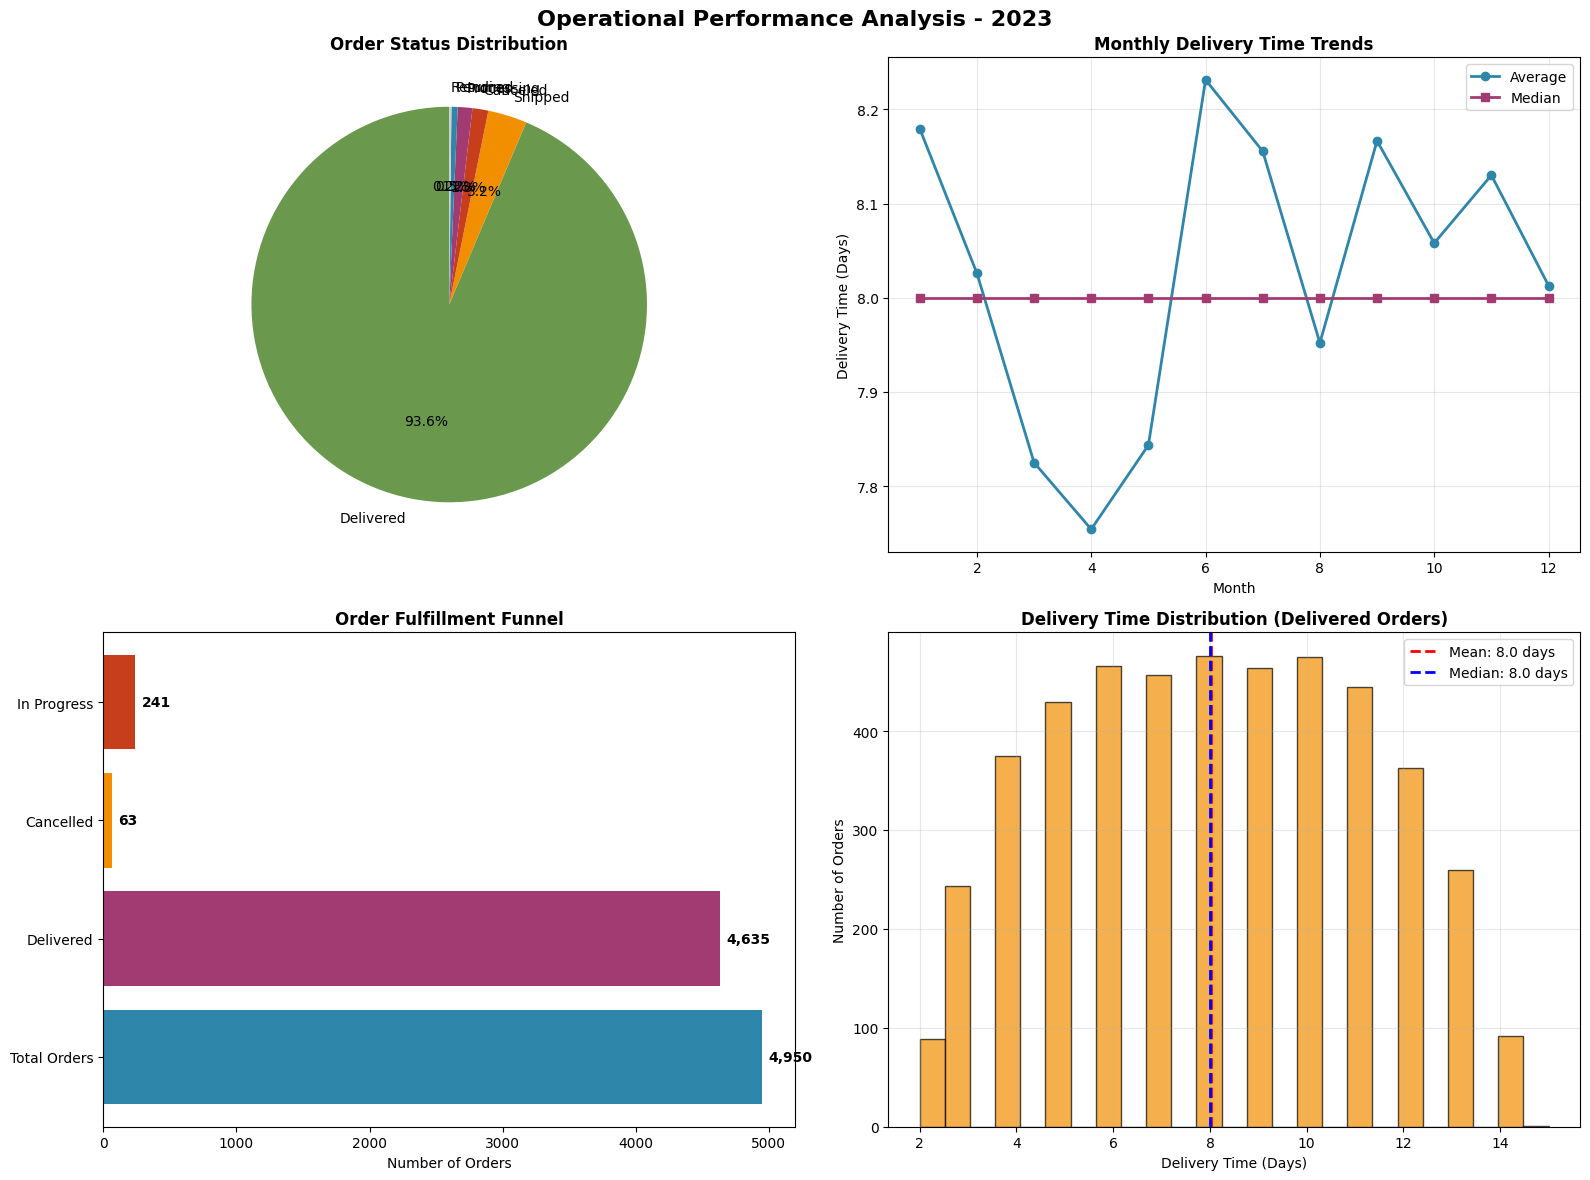

In [24]:
# Operational metrics visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Operational Performance Analysis - {ANALYSIS_YEAR}', fontsize=16, fontweight='bold')

# Order status distribution pie chart
status_colors = {
    'delivered': COLOR_PALETTE[4],  # Green
    'canceled': COLOR_PALETTE[3],   # Red
    'shipped': COLOR_PALETTE[2],    # Orange
    'processing': COLOR_PALETTE[1], # Purple
    'pending': COLOR_PALETTE[0],    # Blue
    'returned': '#CCCCCC'           # Gray
}
pie_colors = [status_colors.get(status, '#CCCCCC') for status in status_distribution.index]

wedges, texts, autotexts = axes[0, 0].pie(status_distribution.values, 
                                          labels=[s.capitalize() for s in status_distribution.index],
                                          autopct='%1.1f%%', startangle=90, colors=pie_colors)
axes[0, 0].set_title('Order Status Distribution', fontweight='bold')

# Delivery time trends by month
if len(delivered_orders) > 0:
    monthly_delivery = (delivered_orders.groupby('order_month')['delivery_time']
                       .agg(['mean', 'median']).reset_index())
    
    axes[0, 1].plot(monthly_delivery['order_month'], monthly_delivery['mean'],
                    marker='o', label='Average', linewidth=2, color=COLOR_PALETTE[0])
    axes[0, 1].plot(monthly_delivery['order_month'], monthly_delivery['median'],
                    marker='s', label='Median', linewidth=2, color=COLOR_PALETTE[1])
    axes[0, 1].set_title('Monthly Delivery Time Trends', fontweight='bold')
    axes[0, 1].set_xlabel('Month')
    axes[0, 1].set_ylabel('Delivery Time (Days)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

# Fulfillment funnel
funnel_stages = ['Total Orders', 'Delivered', 'Cancelled', 'In Progress']
funnel_values = [
    len(total_orders_analysis),
    int(len(total_orders_analysis) * delivered_rate / 100),
    int(len(total_orders_analysis) * cancelled_rate / 100),
    int(len(total_orders_analysis) * pending_rate / 100)
]

bars = axes[1, 0].barh(funnel_stages, funnel_values, color=COLOR_PALETTE[:4])
axes[1, 0].set_title('Order Fulfillment Funnel', fontweight='bold')
axes[1, 0].set_xlabel('Number of Orders')
for bar, value in zip(bars, funnel_values):
    axes[1, 0].text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2,
                    f'{value:,}', ha='left', va='center', fontweight='bold')

# Delivery performance histogram
if len(delivered_orders) > 0:
    axes[1, 1].hist(delivered_orders['delivery_time'], bins=25, 
                    color=COLOR_PALETTE[2], alpha=0.7, edgecolor='black')
    axes[1, 1].axvline(delivered_orders['delivery_time'].mean(), color='red', 
                       linestyle='--', linewidth=2, label=f'Mean: {avg_delivery_time:.1f} days')
    axes[1, 1].axvline(delivered_orders['delivery_time'].median(), color='blue', 
                       linestyle='--', linewidth=2, 
                       label=f'Median: {delivered_orders["delivery_time"].median():.1f} days')
    axes[1, 1].set_title('Delivery Time Distribution (Delivered Orders)', fontweight='bold')
    axes[1, 1].set_xlabel('Delivery Time (Days)')
    axes[1, 1].set_ylabel('Number of Orders')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Business Summary & Insights {#summary}

Comprehensive summary of key business metrics and actionable insights.

In [25]:
# Generate comprehensive business summary
business_summary = generate_business_summary(
    revenue_metrics,
    aov_metrics, 
    order_metrics,
    satisfaction_metrics
)

print(business_summary)


BUSINESS PERFORMANCE SUMMARY

Revenue Analysis:
- Total Revenue: $3,360,294.74
- Revenue Growth: -2.46%
- Period: 2023 vs 2022

Order Metrics:
- Total Orders: 4,635
- Order Growth: -2.40%
- Average Order Value: $724.98
- AOV Growth: -0.06%

Customer Experience:
- Average Review Score: 4.10/5.0
- Average Delivery Time: 8.0 days

Key Insights:
- Revenue declined by 2.5%, indicating potential market challenges
- Customer satisfaction is strong with 4.1/5.0 average rating
- Delivery performance is acceptable but could be improved



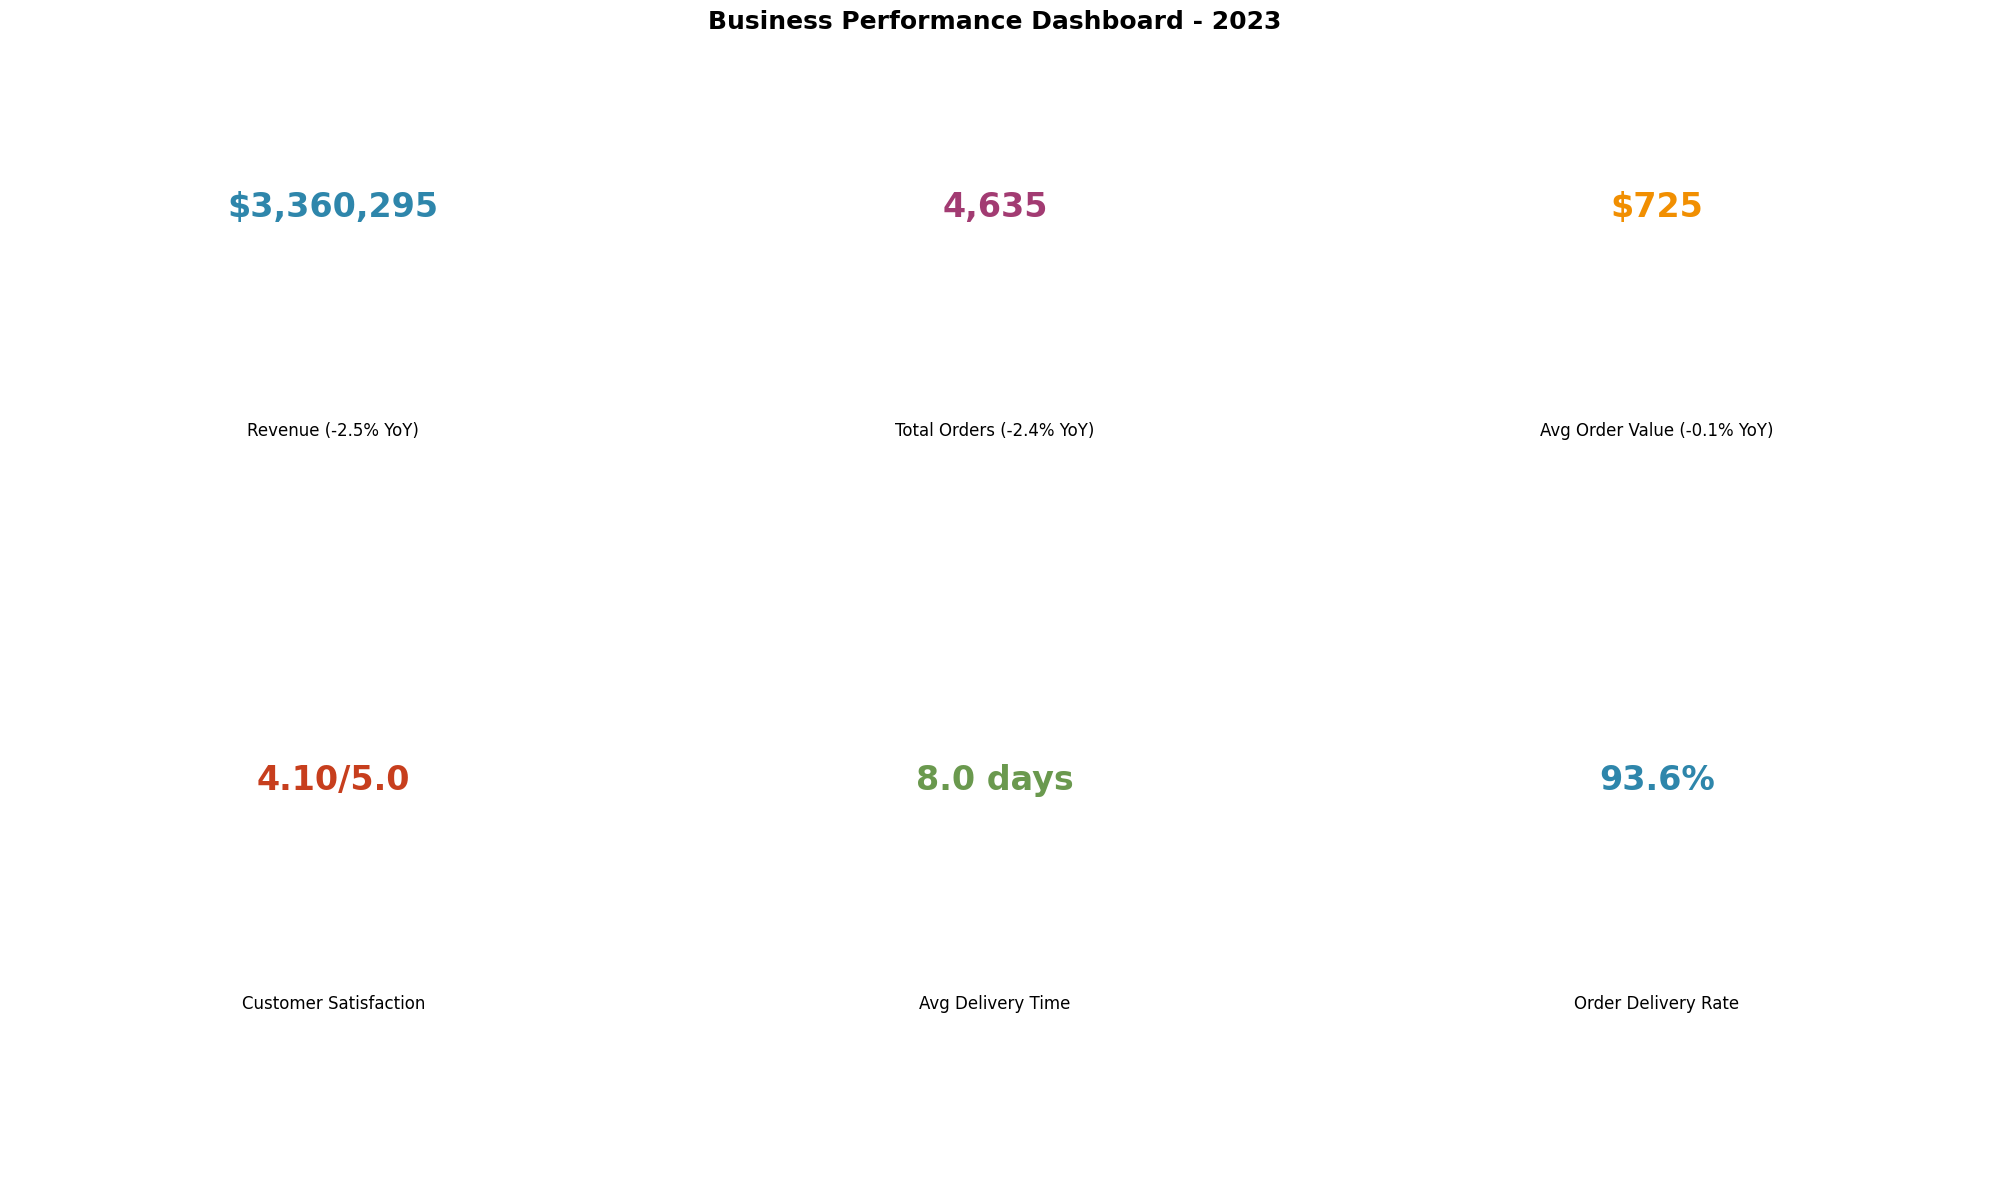

In [26]:
# Key Performance Indicators Dashboard
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle(f'Business Performance Dashboard - {ANALYSIS_YEAR}', fontsize=18, fontweight='bold')

# Revenue KPI
axes[0, 0].text(0.5, 0.7, f"${revenue_metrics['current_revenue']:,.0f}", 
                ha='center', va='center', fontsize=24, fontweight='bold', color=COLOR_PALETTE[0])
axes[0, 0].text(0.5, 0.3, f"Revenue ({revenue_metrics['revenue_growth_pct']:+.1f}% YoY)", 
                ha='center', va='center', fontsize=12)
axes[0, 0].set_xlim(0, 1)
axes[0, 0].set_ylim(0, 1)
axes[0, 0].axis('off')

# Orders KPI
axes[0, 1].text(0.5, 0.7, f"{order_metrics['current_orders']:,}", 
                ha='center', va='center', fontsize=24, fontweight='bold', color=COLOR_PALETTE[1])
axes[0, 1].text(0.5, 0.3, f"Total Orders ({order_metrics['order_growth_pct']:+.1f}% YoY)", 
                ha='center', va='center', fontsize=12)
axes[0, 1].set_xlim(0, 1)
axes[0, 1].set_ylim(0, 1)
axes[0, 1].axis('off')

# AOV KPI
axes[0, 2].text(0.5, 0.7, f"${aov_metrics['current_aov']:.0f}", 
                ha='center', va='center', fontsize=24, fontweight='bold', color=COLOR_PALETTE[2])
axes[0, 2].text(0.5, 0.3, f"Avg Order Value ({aov_metrics['aov_growth_pct']:+.1f}% YoY)", 
                ha='center', va='center', fontsize=12)
axes[0, 2].set_xlim(0, 1)
axes[0, 2].set_ylim(0, 1)
axes[0, 2].axis('off')

# Customer Satisfaction KPI
axes[1, 0].text(0.5, 0.7, f"{satisfaction_metrics['avg_review_score']:.2f}/5.0", 
                ha='center', va='center', fontsize=24, fontweight='bold', color=COLOR_PALETTE[3])
axes[1, 0].text(0.5, 0.3, "Customer Satisfaction", 
                ha='center', va='center', fontsize=12)
axes[1, 0].set_xlim(0, 1)
axes[1, 0].set_ylim(0, 1)
axes[1, 0].axis('off')

# Delivery Time KPI
axes[1, 1].text(0.5, 0.7, f"{satisfaction_metrics['avg_delivery_time_days']:.1f} days", 
                ha='center', va='center', fontsize=24, fontweight='bold', color=COLOR_PALETTE[4])
axes[1, 1].text(0.5, 0.3, "Avg Delivery Time", 
                ha='center', va='center', fontsize=12)
axes[1, 1].set_xlim(0, 1)
axes[1, 1].set_ylim(0, 1)
axes[1, 1].axis('off')

# Delivery Rate KPI
axes[1, 2].text(0.5, 0.7, f"{delivered_rate:.1f}%", 
                ha='center', va='center', fontsize=24, fontweight='bold', color=COLOR_PALETTE[0])
axes[1, 2].text(0.5, 0.3, "Order Delivery Rate", 
                ha='center', va='center', fontsize=12)
axes[1, 2].set_xlim(0, 1)
axes[1, 2].set_ylim(0, 1)
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

## Business Insights and Recommendations

Based on the comprehensive analysis, here are the key findings and recommended actions:

In [27]:
# Generate actionable insights
print("STRATEGIC INSIGHTS AND RECOMMENDATIONS")
print("=" * 50)

# Revenue insights
if revenue_metrics['revenue_growth_pct'] < -2:
    print("\n1. REVENUE RECOVERY PRIORITY:")
    print(f"   - Revenue declined {abs(revenue_metrics['revenue_growth_pct']):.1f}% YoY")
    print("   - Focus on customer acquisition and retention programs")
    print("   - Analyze competitor pricing and market conditions")
elif revenue_metrics['revenue_growth_pct'] < 0:
    print("\n1. REVENUE STABILIZATION:")
    print(f"   - Minor revenue decline of {abs(revenue_metrics['revenue_growth_pct']):.1f}% YoY")
    print("   - Monitor trends closely and implement growth initiatives")
else:
    print("\n1. REVENUE GROWTH MOMENTUM:")
    print(f"   - Strong revenue growth of {revenue_metrics['revenue_growth_pct']:.1f}% YoY")
    print("   - Scale successful strategies and expand market reach")

# Product insights
print("\n2. PRODUCT STRATEGY:")
top_category = category_performance.index[0].replace('_', ' ').title()
top_revenue = category_performance.iloc[0]['total_revenue']
print(f"   - {top_category} is the leading category (${top_revenue:,.0f} revenue)")
print("   - Consider expanding inventory in top-performing categories")
print("   - Evaluate underperforming categories for optimization or discontinuation")

# Geographic insights
print("\n3. GEOGRAPHIC EXPANSION:")
top_state = state_performance.index[0]
top_5_concentration = state_performance.head(5)['total_revenue'].sum() / state_performance['total_revenue'].sum() * 100
print(f"   - {top_state} is the top-performing state")
print(f"   - Top 5 states account for {top_5_concentration:.1f}% of revenue")
if top_5_concentration > 60:
    print("   - High geographic concentration - consider diversification strategies")
else:
    print("   - Good geographic diversification - continue balanced growth")

# Customer experience insights
print("\n4. CUSTOMER EXPERIENCE:")
if satisfaction_metrics['avg_review_score'] >= 4.2:
    print(f"   - Excellent customer satisfaction ({satisfaction_metrics['avg_review_score']:.2f}/5.0)")
    print("   - Leverage high satisfaction for referral programs")
elif satisfaction_metrics['avg_review_score'] >= 4.0:
    print(f"   - Good customer satisfaction ({satisfaction_metrics['avg_review_score']:.2f}/5.0)")
    print("   - Identify and address specific pain points to improve scores")
else:
    print(f"   - Customer satisfaction needs attention ({satisfaction_metrics['avg_review_score']:.2f}/5.0)")
    print("   - Implement immediate customer service improvements")

if satisfaction_metrics['avg_delivery_time_days'] > 10:
    print(f"   - Delivery times are slow ({satisfaction_metrics['avg_delivery_time_days']:.1f} days average)")
    print("   - Optimize logistics and consider faster shipping options")
elif satisfaction_metrics['avg_delivery_time_days'] > 7:
    print(f"   - Delivery performance is acceptable ({satisfaction_metrics['avg_delivery_time_days']:.1f} days average)")
    print("   - Consider premium shipping options for competitive advantage")
else:
    print(f"   - Excellent delivery performance ({satisfaction_metrics['avg_delivery_time_days']:.1f} days average)")
    print("   - Maintain current logistics excellence as a competitive advantage")

# Operational insights
print("\n5. OPERATIONAL EFFICIENCY:")
if delivered_rate >= 95:
    print(f"   - Excellent order fulfillment rate ({delivered_rate:.1f}%)")
elif delivered_rate >= 90:
    print(f"   - Good order fulfillment rate ({delivered_rate:.1f}%)")
    print("   - Focus on reducing cancellations and improving processing speed")
else:
    print(f"   - Order fulfillment needs improvement ({delivered_rate:.1f}%)")
    print("   - Investigate and address operational bottlenecks")

if cancelled_rate > 5:
    print(f"   - High cancellation rate ({cancelled_rate:.1f}%) requires investigation")
    print("   - Analyze cancellation reasons and implement preventive measures")

print("\n" + "=" * 50)
print("Analysis completed successfully!")
print(f"Data covers: {sales_data['order_purchase_timestamp'].min().strftime('%Y-%m-%d')} to {sales_data['order_purchase_timestamp'].max().strftime('%Y-%m-%d')}")
print(f"Total records analyzed: {len(sales_data):,}")

STRATEGIC INSIGHTS AND RECOMMENDATIONS

1. REVENUE RECOVERY PRIORITY:
   - Revenue declined 2.5% YoY
   - Focus on customer acquisition and retention programs
   - Analyze competitor pricing and market conditions

2. PRODUCT STRATEGY:
   - Electronics is the leading category ($1,401,359 revenue)
   - Consider expanding inventory in top-performing categories
   - Evaluate underperforming categories for optimization or discontinuation

3. GEOGRAPHIC EXPANSION:
   - CA is the top-performing state
   - Top 5 states account for 50.3% of revenue
   - Good geographic diversification - continue balanced growth

4. CUSTOMER EXPERIENCE:
   - Good customer satisfaction (4.10/5.0)
   - Identify and address specific pain points to improve scores
   - Delivery performance is acceptable (8.0 days average)
   - Consider premium shipping options for competitive advantage

5. OPERATIONAL EFFICIENCY:
   - Good order fulfillment rate (93.6%)
   - Focus on reducing cancellations and improving processing sp